# 1. Data Preparation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16,
                                        shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truch')

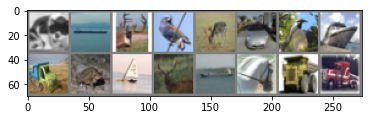

  cat  ship  deer  bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
print(images.shape)

torch.Size([16, 3, 32, 32])


# 2. Model Architecture

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()
            
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

#net = MLP(3*32*32, 10, 100, 4, 'relu')

# 3. Define Experiment

In [7]:
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()
    print(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):
        
        ## Train ##
        net.train()
        
        running_loss = 0
        train_loss = 0

        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()

            inputs, labels = data
            inputs = inputs.view(-1, 3072)

            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loss += loss.item()
            #if i % 500 == 499:
            #    print('[%d, %5d] loss: %.3f'%(epoch+1, i+1, running_loss / 500))
            #    running_loss = 0
        
        ## Validate ##
        net.eval()
        
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.view(-1, 3072)
                
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct / total
        
        print('Epoch:{}, Train Loss:{}, Val Loss:{}, Val Acc:{}'.format(epoch, train_loss, val_loss, val_acc))
    
    ## Evaluate ##
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.view(-1, 3072)
            
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        test_acc = 100 * correct / total
        print('test_acc:', test_acc)

# 4. Experiment

In [8]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3 * 32 * 32
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epoch = 5

In [11]:
list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]
for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print('')

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
Epoch:0, Train Loss:5345.513512253761, Val Loss:1.909885383415222, Val Acc:28.56
Epoch:1, Train Loss:4498.120024085045, Val Loss:1.712243480682373, Val Acc:38.66
Epoch:2, Train Loss:4114.945496737957, Val Loss:1.5932987495422364, Val Acc:41.98
Epoch:3, Train Loss:3864.3928371071815, Val Loss:1.5408321807861327, Val Acc:44.48
Epoch:4, Train Loss:3693.599429965019, Val Loss:1.4949379609107971, Val Acc:46.21
test_acc: 47.48

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (